# 1 Million Brain Cells
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working environment with all nessaray dependencies. Run the [data_downloader](https://github.com/scverse/rapids_singlecell-notebooks/blob/abc4fc6f3fe7f85cbffb94e76d190cad0ae00a5f/data_downloader.ipynb) notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 1000000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
import gc

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/nvidia_1.3M.h5ad")
adata.var_names_make_unique()
adata = adata[:1_000_000, :].copy()

CPU times: user 1min 36s, sys: 33.4 s, total: 2min 9s
Wall time: 2min 9s


We now load the the AnnData object into VRAM.

In [6]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 1.26 s, sys: 6.56 s, total: 7.81 s
Wall time: 7.81 s


Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(1000000, 27998)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 137.5298295021057


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic quality control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 3.74 ms, sys: 893 μs, total: 4.64 ms
Wall time: 4.56 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])

CPU times: user 313 ms, sys: 14.7 ms, total: 328 ms
Wall time: 327 ms


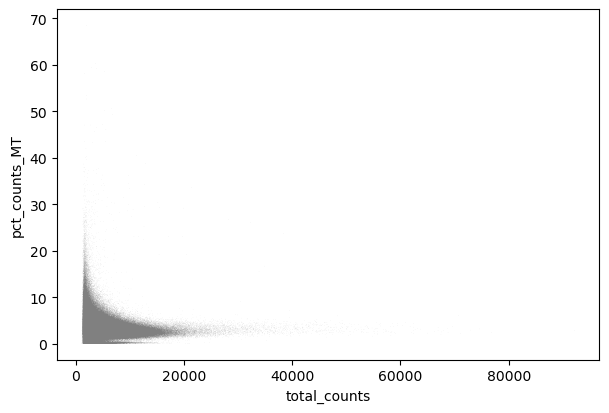

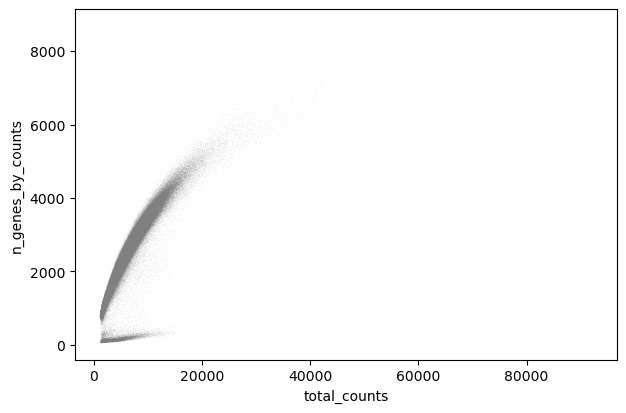

CPU times: user 4.06 s, sys: 426 ms, total: 4.49 s
Wall time: 3.95 s


In [12]:
%%time
sc.pl.scatter(adata, "total_counts", "pct_counts_MT")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

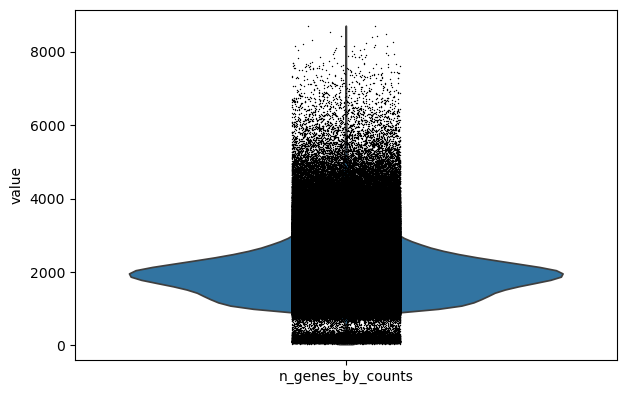

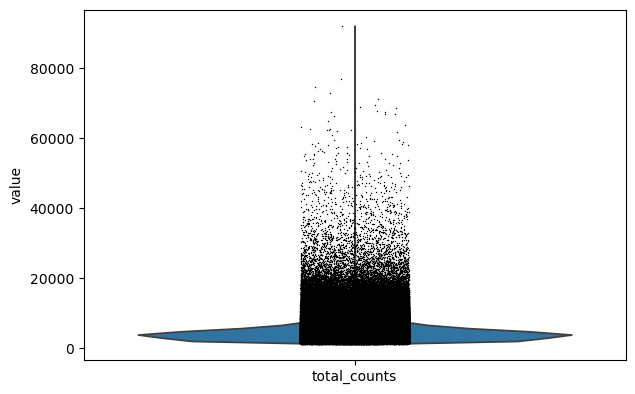

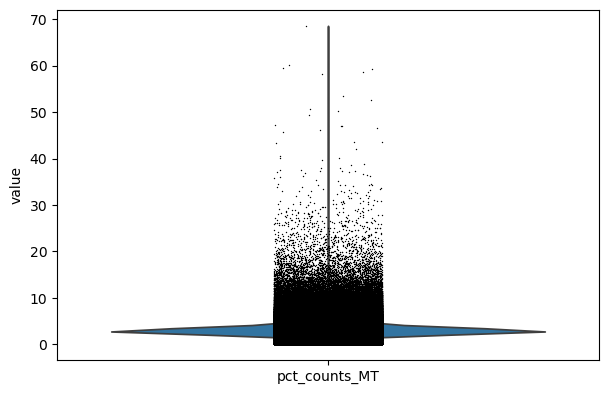

CPU times: user 1min 7s, sys: 23.9 s, total: 1min 30s
Wall time: 10.6 s


In [13]:
%%time
sc.pl.violin(adata, keys="n_genes_by_counts")
sc.pl.violin(adata, keys="total_counts")
sc.pl.violin(adata, keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[
    (adata.obs["n_genes_by_counts"] < 5000)
    & (adata.obs["n_genes_by_counts"] > 500)
    & (adata.obs["pct_counts_MT"] < 20)
].copy()

CPU times: user 410 ms, sys: 91.1 ms, total: 501 ms
Wall time: 500 ms


Many python objects are not deallocated until garbage collection runs. When working with data that barely fits in memory (generally, >50%) you may need to manually trigger garbage collection to reclaim memory.

In [15]:
%%time
gc.collect()

CPU times: user 155 ms, sys: 43 ms, total: 198 ms
Wall time: 197 ms


49866

We also filter out genes that are expressed in less than 3 cells.

In [ ]:
%%time
rsc.pp.filter_genes(adata, min_count=3)

We store the raw expression counts in the `.layer["counts"]`

In [17]:
adata.layers["counts"] = adata.X.copy()

In [18]:
adata.shape

(982490, 27998)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 10.6 ms, sys: 241 μs, total: 10.9 ms
Wall time: 10.7 ms


Next, we log transform the count matrix.

In [20]:
%%time
rsc.pp.log1p(adata)

CPU times: user 72 ms, sys: 15.1 ms, total: 87.1 ms
Wall time: 86.6 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`. 

In [21]:
%%time
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="seurat_v3", layer="counts"
)

CPU times: user 2.94 s, sys: 170 ms, total: 3.11 s
Wall time: 3.11 s


In [22]:
%%time
rsc.get.anndata_to_CPU(adata, layer="counts")

CPU times: user 2.35 s, sys: 2.02 s, total: 4.37 s
Wall time: 4.37 s


Now we safe this version of the AnnData as adata.raw.

In [23]:
%%time
adata.raw = adata

CPU times: user 2.33 s, sys: 2.03 s, total: 4.36 s
Wall time: 4.36 s


Now we restrict our AnnData object to the highly variable genes.

In [24]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 2.06 s, sys: 2.1 s, total: 4.16 s
Wall time: 4.16 s


In [25]:
adata.shape

(982490, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 13.8 s, sys: 3.69 s, total: 17.5 s
Wall time: 18.3 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 348 ms, sys: 11.3 ms, total: 359 ms
Wall time: 359 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuml to run this. With `use_highly_variable = False` we save VRAM since we already subset the matrix to only HVGs.

In [28]:
%%time
rsc.pp.pca(adata, n_comps=100, use_highly_variable=False)

CPU times: user 2.09 s, sys: 159 ms, total: 2.25 s
Wall time: 2.29 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

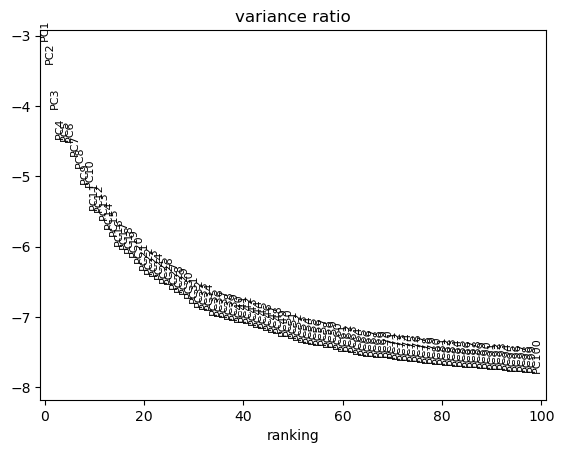

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [30]:
%%time
rsc.get.anndata_to_CPU(adata)

CPU times: user 2.82 s, sys: 2.44 s, total: 5.25 s
Wall time: 5.23 s


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 58.26481556892395


Visualization## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [32]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

CPU times: user 10.7 s, sys: 339 ms, total: 11 s
Wall time: 11 s


Next we calculate the UMAP embedding using rapdis.

In [33]:
%%time
rsc.tl.umap(adata, min_dist=0.3)

CPU times: user 849 ms, sys: 195 ms, total: 1.04 s
Wall time: 1.04 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [34]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 2.23 s, sys: 1.63 s, total: 3.87 s
Wall time: 4.68 s


In [35]:
%%time
rsc.tl.leiden(adata, resolution=1.0)

CPU times: user 1.74 s, sys: 1.14 s, total: 2.88 s
Wall time: 2.88 s


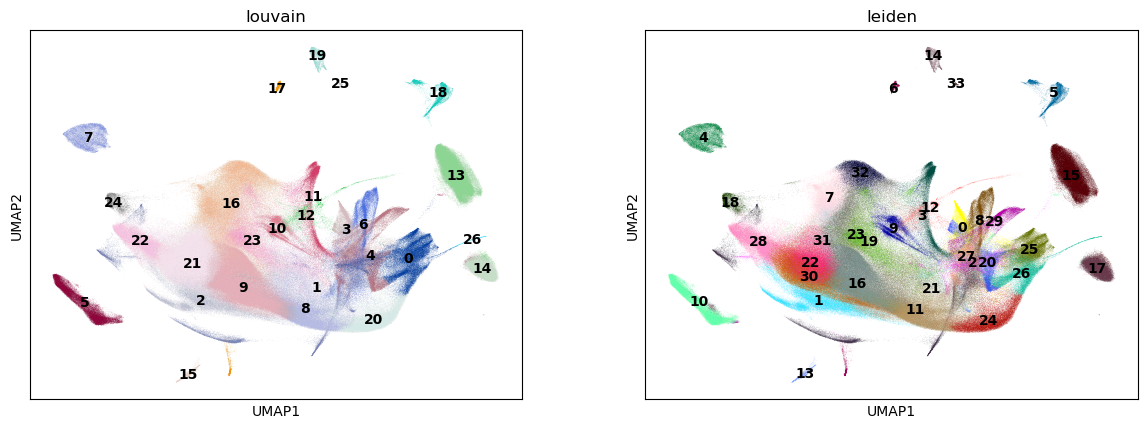

CPU times: user 5.22 s, sys: 301 ms, total: 5.52 s
Wall time: 5.25 s


In [36]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

## TSNE

In [37]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [21:00:47.622628] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 13.4 s, sys: 4.47 s, total: 17.8 s
Wall time: 17.8 s


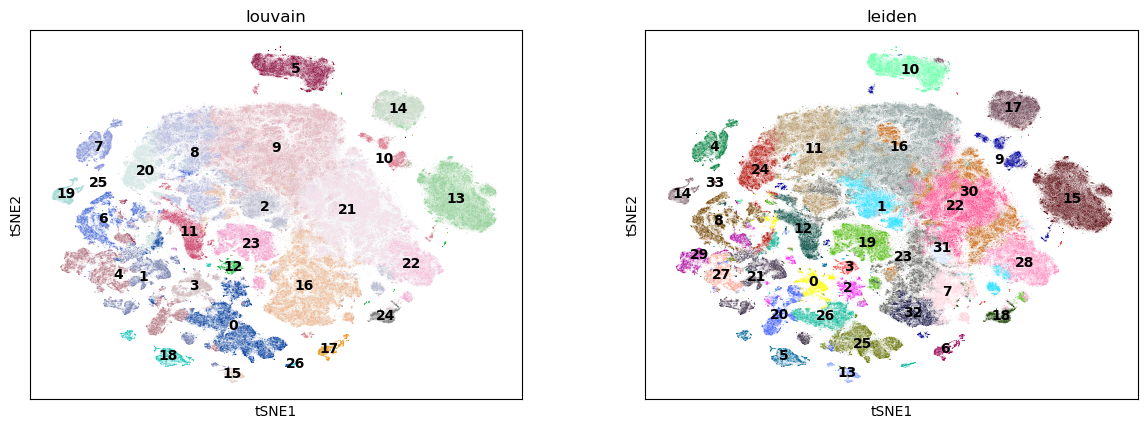

In [38]:
sc.pl.tsne(adata, color=["louvain", "leiden"], legend_loc="on data")

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [39]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [21:01:53.288248] L-BFGS: max iterations reached
[W] [21:01:53.289256] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 23.3 s, sys: 20.4 s, total: 43.7 s
Wall time: 43.6 s


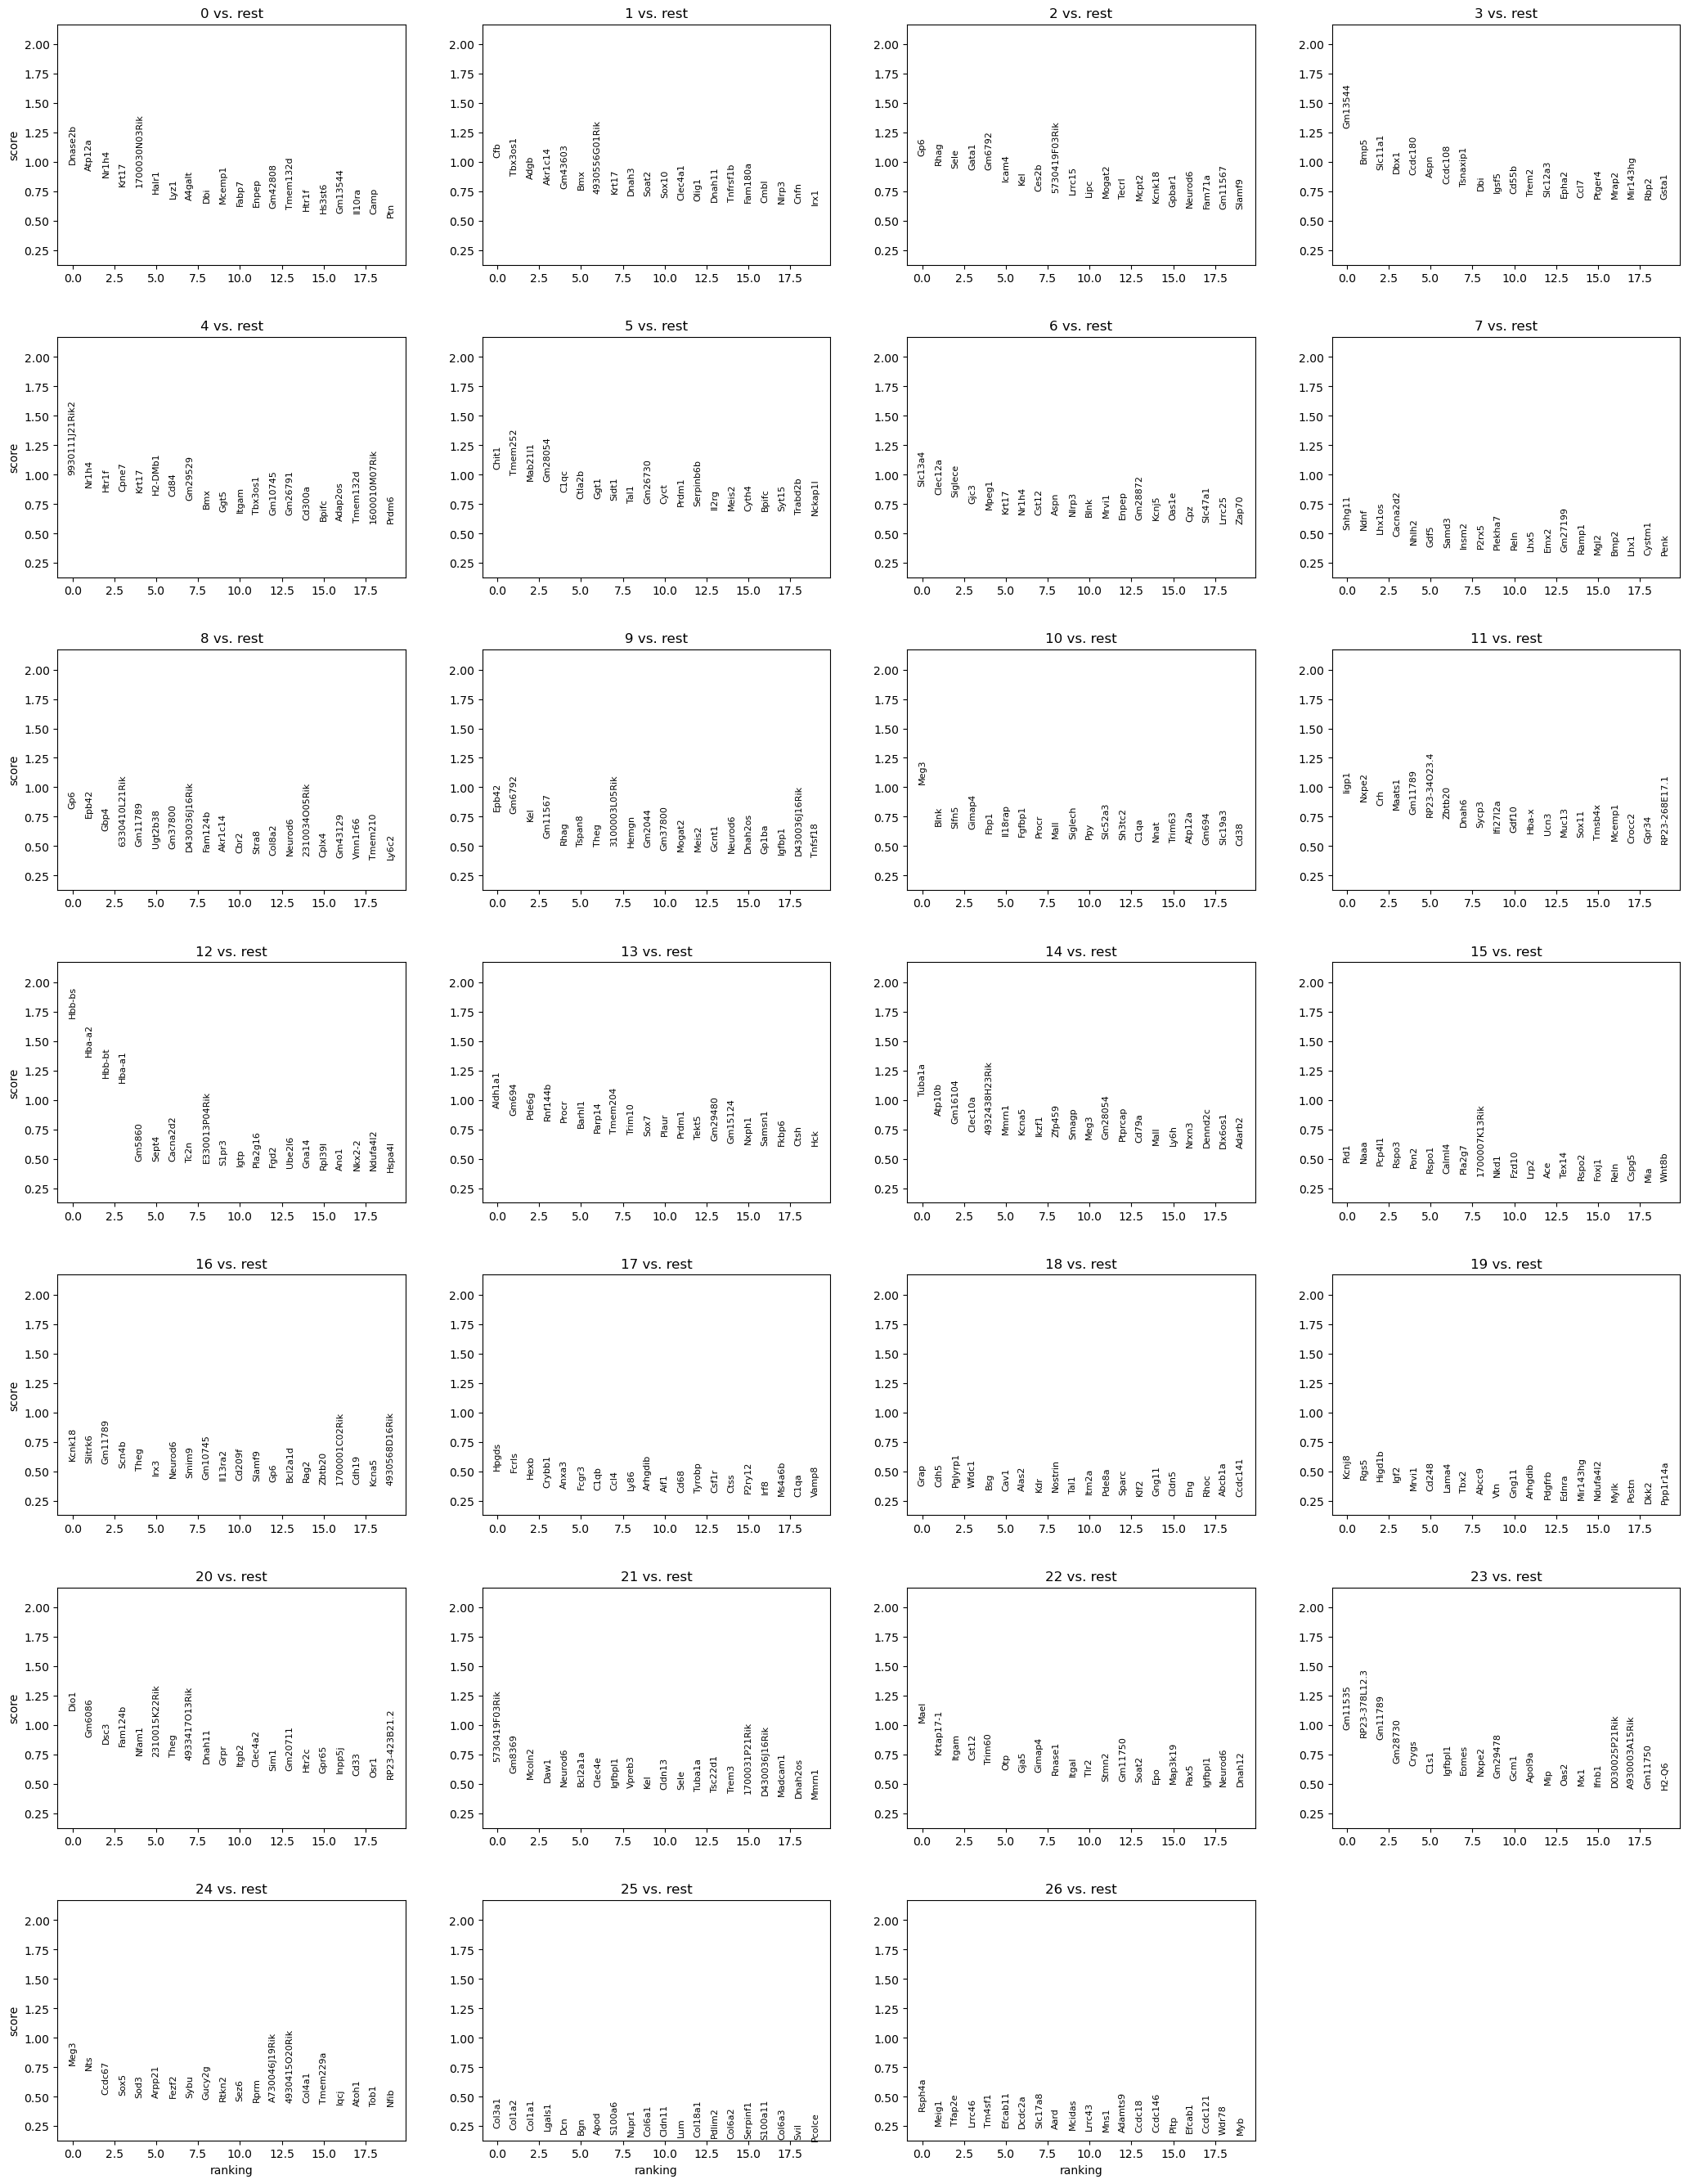

CPU times: user 2.39 s, sys: 387 ms, total: 2.78 s
Wall time: 2.51 s


In [40]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [41]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

CPU times: user 3.06 s, sys: 290 ms, total: 3.35 s
Wall time: 4.41 s


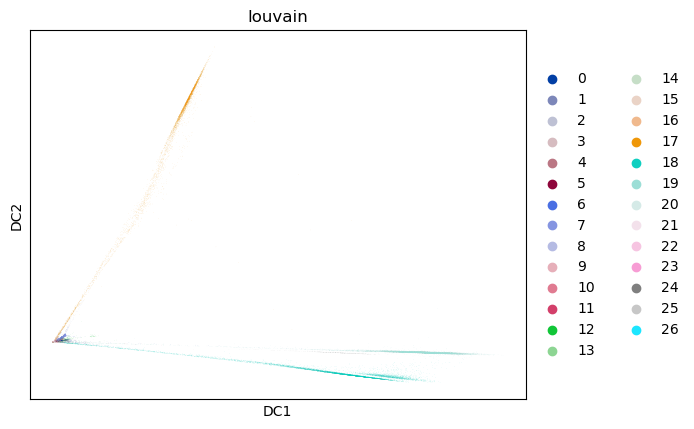

In [42]:
sc.pl.diffmap(adata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [43]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 159.57574892044067
